# • Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
# %%capture
# !pip install hierarchicalforecast
# !pip install -U numba statsforecast datasetsforecast

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasetsforecast.hierarchical import HierarchicalData

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.utils import HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.evaluation import scaled_crps

from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

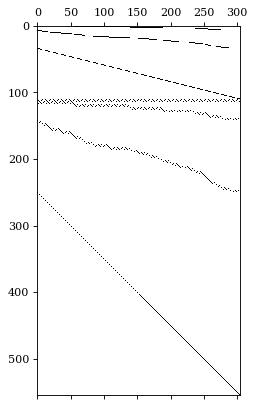

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(12)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [ ]:
Y_train_df

,ds,y
unique_id,,
TotalAll,1998-01-01,45151.071280
TotalAll,1998-02-01,17294.699551
TotalAll,1998-03-01,20725.114184
TotalAll,1998-04-01,25388.612353
TotalAll,1998-05-01,20330.035211
...,...,...
GBDOth,2015-08-01,17.683774
GBDOth,2015-09-01,0.000000
GBDOth,2015-10-01,0.000000


### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
if os.path.isfile('Y_hat.csv'):
    Y_hat_df = pd.read_csv('Y_hat.csv')
    Y_fitted_df = pd.read_csv('Y_fitted.csv')

    Y_hat_df = Y_hat_df.set_index('unique_id')
    Y_fitted_df = Y_fitted_df.set_index('unique_id')
else:
    fcst = StatsForecast(
        df=Y_train_df, 
        models=[AutoARIMA(season_length=12)],
        fallback_model=[Naive()],
        freq='M', 
        n_jobs=-1
    )
    Y_hat_df = fcst.forecast(h=12, fitted=True, level=[80])
    Y_fitted_df = fcst.forecast_fitted_values()
    Y_hat_df.to_csv('Y_hat.csv')
    Y_fitted_df.to_csv('Y_fitted.csv')

In [ ]:
Y_hat_df

,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
unique_id,,,,
AAAAll,2015-12-31,2980.2920,2616.2852,3344.2986
AAAAll,2016-01-31,1583.3505,1210.3552,1956.3457
AAAAll,2016-02-29,1917.7720,1540.1355,2295.4084
AAAAll,2016-03-31,1853.5470,1469.3541,2237.7400
AAAAll,2016-04-30,1826.0084,1439.3937,2212.6233
...,...,...,...,...
TotalVis,2016-07-31,6658.2400,5652.0796,7664.4010
TotalVis,2016-08-31,6659.7310,5649.2130,7670.2495
TotalVis,2016-09-30,7787.8657,6775.1343,8800.5980


In [ ]:
Y_fitted_df

,ds,y,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
unique_id,,,,,
AAAAll,1998-01-01,3743.0562,3739.3130,3375.3071,4103.3193
AAAAll,1998-02-01,1691.6644,1689.9728,1325.9668,2053.9788
AAAAll,1998-03-01,1874.1469,1872.2727,1508.2667,2236.2788
AAAAll,1998-04-01,2206.4634,2204.2568,1840.2509,2568.2630
AAAAll,1998-05-01,2161.1172,2158.9560,1794.9501,2522.9622
...,...,...,...,...,...
TotalVis,2015-08-01,7562.1084,6709.5376,5755.7812,7663.2940
TotalVis,2015-09-01,7067.2080,6717.6850,5763.9287,7671.4414
TotalVis,2015-10-01,8082.1560,7943.0386,6989.2820,8896.7950


## 3. Reconciliate Predictions

In [ ]:
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

reconcilers = [
    BottomUp(),
    MinTrace(method='ols'),
    #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
    ERM(method='closed')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
                          Y_df=Y_fitted_df,
                          S=S_df, tags=tags,
                          level=level,
                          intervals_method='bootstrap')

100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


## 4. Evaluation

In [ ]:
# Matching Y_test/Y_rec/S index ordering
Y_test_df = Y_test_df.reset_index()
Y_test_df.unique_id = Y_test_df.unique_id.astype('category')
Y_test_df.unique_id = Y_test_df.unique_id.cat.set_categories(S_df.index)
Y_test_df = Y_test_df.sort_values(by=['unique_id', 'ds'])

Y_rec_df = Y_rec_df.reset_index()
Y_rec_df.unique_id = Y_rec_df.unique_id.astype('category')
Y_rec_df.unique_id = Y_rec_df.unique_id.cat.set_categories(S_df.index)
Y_rec_df = Y_rec_df.sort_values(by=['unique_id', 'ds'])
Y_rec_df

,unique_id,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA/BottomUp,AutoARIMA/BottomUp-lo-98,AutoARIMA/BottomUp-lo-96,AutoARIMA/BottomUp-lo-94,AutoARIMA/BottomUp-lo-92,...,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-80,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-82,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-84,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-86,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-88,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-90,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-92,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-94,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-96,AutoARIMA/ERM_method-closed_lambda_reg-0.01-hi-98
6600,TotalAll,2015-12-31,46343.890,44287.180000,48400.605000,42111.652510,39596.250985,39871.197404,40128.699966,40136.490709,...,46716.861349,46736.068577,47054.329120,47325.659713,47602.242981,47665.632818,47842.511242,48077.595307,48082.083597,48302.009804
6601,TotalAll,2016-01-31,21098.996,19032.943000,23165.050000,18897.595244,16555.651287,16922.433443,16922.433443,17625.272009,...,24792.061475,24895.697176,24966.178314,25021.418571,25219.985949,25346.795750,25889.539277,26228.377150,26631.050796,27123.844249
6602,TotalAll,2016-02-29,24797.059,22697.545000,26896.570000,21741.049626,19180.530405,19225.192366,19503.036074,19506.196370,...,29412.837396,29475.652352,29481.320138,29546.499673,29647.046487,30118.007499,30197.707018,30589.266011,30593.359825,31082.017259
6603,TotalAll,2016-03-31,29107.896,26978.336000,31237.457000,25149.086345,22807.142388,22912.126225,23423.434402,23876.763110,...,31617.992578,31747.448308,31792.196526,31796.593573,31857.268912,31925.858803,32382.760065,32504.421149,32968.498528,32972.718954
6604,TotalAll,2016-04-30,23126.271,20966.814000,25285.727000,19770.418411,17534.511723,18052.483268,18580.282803,18947.005642,...,27310.489826,27453.502937,27522.641592,27584.905459,27736.511525,27868.731032,28341.785021,28402.639265,28574.400086,28574.400086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,GBDOth,2016-07-31,0.000,-3.565787,3.565787,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.441461,18.045948,19.036552,20.044273,20.044400,20.590594,21.681518,22.970473,28.075463,28.136013
6500,GBDOth,2016-08-31,0.000,-3.565787,3.565787,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.400271,7.063581,7.084384,7.161316,7.799773,8.855132,9.211519,9.375201,10.230755,12.937254
6501,GBDOth,2016-09-30,0.000,-3.565787,3.565787,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.209657,4.394540,4.643439,4.674677,5.676908,7.237288,7.810032,10.585469,10.592476,11.625817
6502,GBDOth,2016-10-31,0.000,-3.565787,3.565787,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.975005,3.056975,3.191234,3.451459,3.946823,4.522978,4.562236,5.507863,6.153476,9.372472


In [ ]:
# Hardcoded quantiles' parsing
bottom_up_cols    = [col for col in Y_rec_df.columns if 'AutoARIMA/BottomUp-' in col]
erm_closed_cols   = [col for col in Y_rec_df.columns if 'ERM_method-closed_lambda_reg-0.01-' in col]
mintrace_ols_cols = [col for col in Y_rec_df.columns if 'AutoARIMA/MinTrace_method-ols-' in col]

y_rec  = Y_rec_df[bottom_up_cols + erm_closed_cols + mintrace_ols_cols]
model_columns = y_rec.columns

y_rec = y_rec.values.reshape(555, 12, len(model_columns))
y_test = Y_test_df['y'].values.reshape(555, 12)

print('y_rec.shape', y_rec.shape)
print('y_test.shape', y_test.shape)

y_rec.shape (555, 12, 300)
y_test.shape (555, 12)


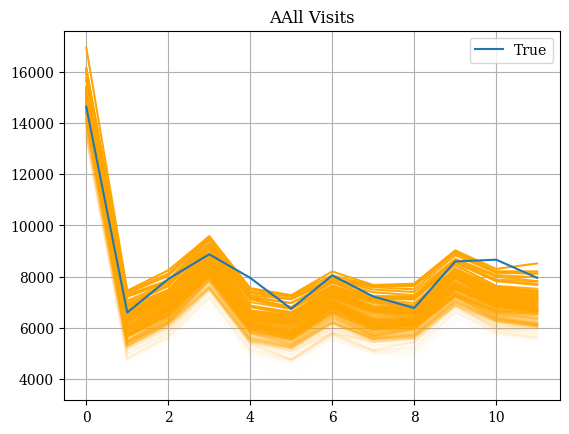

In [ ]:
# Qualitative evaluation, of parsed quantiles
row_idx = 1
col_idxs = model_columns.get_indexer(bottom_up_cols)
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[row_idx,:,col], color='orange', alpha=i/100)
plt.plot(y_test[row_idx,:], label='True')
plt.title(f'{S_df.index[row_idx]} Visits')

plt.legend()
plt.grid()
plt.show()
plt.close()

In [ ]:
models = {'AutoARIMA/BottomUp-': bottom_up_cols, 
          'ERM_method-closed_lambda_reg-0.01-': erm_closed_cols,
          'AutoARIMA/MinTrace_method-ols-': mintrace_ols_cols}

results = {'Level': ['Overall'] + list(tags.keys()),
           'AutoARIMA/BottomUp-': [], 
           'ERM_method-closed_lambda_reg-0.01-': [],
           'AutoARIMA/MinTrace_method-ols-': []}
for model in models:
    for level in results['Level']:
        if level=='Overall':
            _y = y_test
            _y_rec = y_rec[:,:,col_idxs]
        else:
            row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(models[model])
            #print(f'{level} row_idxs', row_idxs)
            #print(f'{model} col_idxs', col_idxs)
            _y = y_test[row_idxs,:]
            _y_rec = y_rec[row_idxs,:,:][:,:,col_idxs]
        level_model_crps = scaled_crps(y=_y, y_hat=_y_rec,
                                       quantiles=quantiles)
        results[model].append(level_model_crps)
results = pd.DataFrame(results)
results

,Level,AutoARIMA/BottomUp-,ERM_method-closed_lambda_reg-0.01-,AutoARIMA/MinTrace_method-ols-
0,Overall,0.142283,0.142283,0.146917
1,Country,0.069628,0.029317,0.028394
2,Country/State,0.087255,0.070817,0.062007
3,Country/State/Zone,0.125604,0.125380,0.114381
4,Country/State/Zone/Region,0.169314,0.182755,0.168777
5,Country/Purpose,0.084604,0.081875,0.075731
6,Country/State/Purpose,0.131262,0.139612,0.123177
7,Country/State/Zone/Purpose,0.198847,0.226038,0.198384
8,Country/State/Zone/Region/Purpose,0.271752,0.319538,0.283941


## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)